# Preparing the environment

## Import of Libraries

In [ ]:
#!pip install -q tensorflow==2.3
#!pip install albumentations -q # image augmentation
!pip install catboost
!pip install pymorphy2

     |████████████████████████████████| 67.4 MB 27 kB/s 
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 10.9 MB/s 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import random
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
import sys
import PIL
import cv2
import re
import pickle

from pandas import Series
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# nltk
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
import pymorphy2

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt

# increase the default size of charts
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# svg charts looks more sharp
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.11 (default, Jul  3 2021, 18:01:19) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0


##Functions

In [ ]:
RANDOM_SEED = 42

# MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# visualization of numerical features
def visualizing_number(column): 
    bins = 100
    if column.nunique() < 100:
        bins = column.nunique()
    column.hist(bins = bins)
    plt.show()
    sns.boxplot(y = column,data=data)
    plt.show()
    
# outliers count
def get_outliers(column): 
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    min_out = Q1 - 1.5 * IQR
    max_out = Q3 + 1.5 * IQR
    return (column < min_out).sum() + (column > max_out).sum(), min_out, max_out

In [ ]:
!pip freeze > requirements.txt

#Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_DIR = '/content/gdrive/MyDrive/Colab Notebooks/SF/PROJECTS/Car Price Prediction_Part 2/data/'

In [ ]:
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [ ]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [ ]:
train['sample'] = 1 # mark where we have train
test['sample'] = 0 # mark where we have test
test['price'] = 0 # target, fill it with zeros for now

In [ ]:
# Combine train and test into one dataset
data = test.append(train, sort=False).reset_index(drop=True)
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [ ]:
data = data.rename(columns={'bodyType': 'body_type', 'engineDisplacement': 'engine_displacement',
                            'enginePower': 'engine_power', 'fuelType': 'fuel_type',
                            'modelDate': 'model_date', 'numberOfDoors': 'number_of_doors',
                            'productionDate': 'production_date', 'vehicleConfiguration': 'vehicle_configuration',
                            'vehicleTransmission': 'vehicle_transmission', 'Владельцы': 'owners',
                            'Владение': 'ownership', 'ПТС': 'vehicle_passport',
                            'Привод': 'car_drive', 'Руль': 'steering_wheel'})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   body_type              8353 non-null   object 
 1   brand                  8353 non-null   object 
 2   color                  8353 non-null   object 
 3   description            8353 non-null   object 
 4   engine_displacement    8353 non-null   object 
 5   engine_power           8353 non-null   object 
 6   fuel_type              8353 non-null   object 
 7   mileage                8353 non-null   int64  
 8   model_date             8353 non-null   int64  
 9   model_info             8353 non-null   object 
 10  name                   8353 non-null   object 
 11  number_of_doors        8353 non-null   int64  
 12  production_date        8353 non-null   int64  
 13  sell_id                8353 non-null   int64  
 14  vehicle_configuration  8353 non-null   object 
 15  vehi

We noticed that there are missing values only in the owners and ownership features. Let's keep it in mind.

In [ ]:
data.nunique()

body_type                  17
brand                       3
color                      16
description              7654
engine_displacement        48
engine_power              154
fuel_type                   4
mileage                  3507
model_date                 43
model_info                122
name                      976
number_of_doors             4
production_date            39
sell_id                  8353
vehicle_configuration     312
vehicle_transmission        4
owners                      3
ownership                 180
vehicle_passport            2
car_drive                   3
steering_wheel              2
sample                      2
price                    1629
dtype: int64

Let's take a look at the types of features

- body_type - categorical
- brand - categorical
- color - categorical
- description - text
- engine_displacement - numeric, represented as text
- engine_power - numeric, represented as text
- fuel_type - categorical
- mileage - numeric
- model_date - numeric
- model_info - categorical
- name - categorical, it's desirable to reduce the dimension
- number_of_doors - categorical
- price - numeric, target
- production_date - numeric
- sell_id - image (the file is available at an address based on sell_id)
- vehicle_configuration - not used (combination of other columns)
- vehicle_transmission - categorical
- owners - categorical
- ownership - numeric, represented as text
- vehicle_passport - categorical
- car_drive - categorical
- steering_wheel - categorical

# Naive Model

This model will predict the average price by model and year of production. We will compare other models with it.

In [ ]:
train_upd = data.query('sample == 1').drop(['sell_id', 'sample'], axis=1)

In [ ]:
# data split
data_train, data_test = train_test_split(train_upd, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# naive model
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'production_date']]).iterrows():
    query = f"model_info == '{row[0]}' and production_date == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# fill in not found matches
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# round
predicts = (predicts // 1000) * 1000

# evaluate the accuracy
print(f"Accuracy of a naive model by metric MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Accuracy of a naive model by metric MAPE: 19.88%


# Heuristic check

Let's carry out a quick analysis of the data in order to understand whether our algorithm can work with this data.

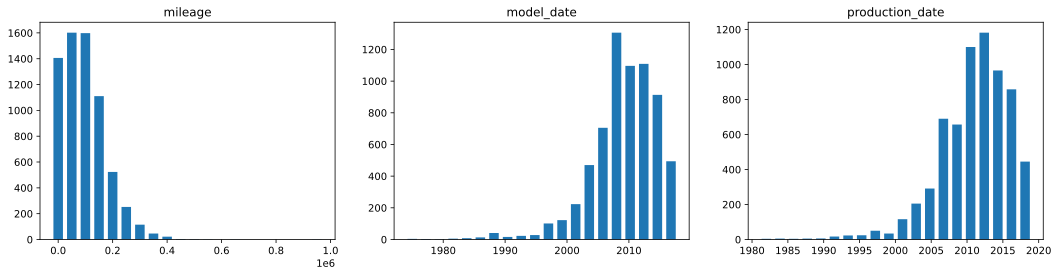

In [ ]:
# let's look at the distribution of numerical features
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train_upd['mileage'].dropna(),
    'model_date': train_upd['model_date'].dropna(),
    'production_date': train_upd['production_date'].dropna()
})

Subtotal: CatBoost can work with features in this form, but we need to normalize the data for the neural network.

# EDA

## Feature processing

In [ ]:
data.columns

Index(['body_type', 'brand', 'color', 'description', 'engine_displacement',
       'engine_power', 'fuel_type', 'mileage', 'model_date', 'model_info',
       'name', 'number_of_doors', 'production_date', 'sell_id',
       'vehicle_configuration', 'vehicle_transmission', 'owners', 'ownership',
       'vehicle_passport', 'car_drive', 'steering_wheel', 'sample', 'price'],
      dtype='object')

Create empty lists for categorical, numerical and binary features. We will gradually fill them in:

In [ ]:
cat_cols = []
num_cols = []
bin_cols = []

### body_type

In [ ]:
# Let's look at the unique data of this feature
data.body_type.value_counts()

седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: body_type, dtype: int64

In [ ]:
# Let's leave only the names of the bodies
data['body_type'] = data['body_type'].str.extract(r"(\w+)", expand=True)

In [ ]:
data.body_type.value_counts()

седан          3542
внедорожник    2905
купе            654
хэтчбек         421
лифтбек         299
универсал       196
минивэн         178
родстер          88
кабриолет        54
компактвэн        8
лимузин           5
пикап             3
Name: body_type, dtype: int64

Decrease the dimension of the feature

In [ ]:
# Let's create a mini dataset with body types
body_min = data.groupby(['body_type']).size().reset_index(name='counts') 

In [ ]:
# Let's leave all popular values in the mini dataset (the number of entries > 100 times)
body_min_popular = body_min.loc[body_min.counts > 100]['body_type'].unique()

In [ ]:
# Let's replace all unpopular values with the new combined group OTHER
for i in body_min['body_type']:
    if i not in body_min_popular:
        data.loc[data['body_type'] == i, 'body_type'] = 'OTHER'

In [ ]:
data.body_type.value_counts()

седан          3542
внедорожник    2905
купе            654
хэтчбек         421
лифтбек         299
универсал       196
минивэн         178
OTHER           158
Name: body_type, dtype: int64

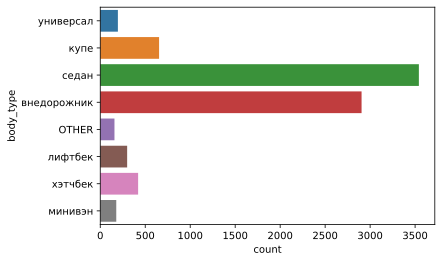

In [ ]:
# The most popular bodies are sedan and SUV
sns.countplot(y = data['body_type'], data = data)

In [ ]:
cat_cols.append('body_type')

### brand

In [ ]:
data.brand.value_counts()

BMW         3535
MERCEDES    2846
AUDI        1972
Name: brand, dtype: int64

In [ ]:
cat_cols.append('brand')

### color 

In [ ]:
data.color.value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
пурпурный        38
оранжевый        30
золотистый       24
жёлтый           17
розовый           1
Name: color, dtype: int64

Decrease the dimension of the feature

In [ ]:
# Let's create a mini dataset with colors
color_min = data.groupby(['color']).size().reset_index(name='counts') 

In [ ]:
# Let's leave all popular values in the mini dataset (the number of entries > 40 times)
color_min_popular = color_min.loc[color_min.counts > 40]['color'].unique()

In [ ]:
# Let's replace all unpopular values with the new combined group OTHER
for i in color_min['color']:
    if i not in color_min_popular:
        data.loc[data['color'] == i, 'color'] = 'OTHER'

In [ ]:
data.color.value_counts()

чёрный         3468
белый          1607
серый           925
синий           863
серебристый     420
коричневый      386
красный         266
OTHER           110
голубой          91
зелёный          86
бежевый          85
фиолетовый       46
Name: color, dtype: int64

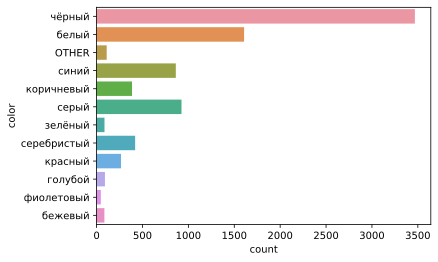

In [ ]:
# The most popular colors are black and white
sns.countplot(y = data['color'], data = data)

In [ ]:
cat_cols.append('color')

### description

In [ ]:
data.description.unique()

array(['Всем привет!\n\nПродам эксклюзивный проект 124 универсал 300TE-24 SportLine\n\nМодель 124.091 300 TE-24\nДвигатель 104.980\nТрансмиссия 722.359\nЦвет кузова 040 (черный)\nОтделка салона 271 (Кожа черная / "антрацит")\n\nОпции:\n211 Автоматическая блокировка дифференциала (ASD)\n240 Индикатор внешней температуры\n244 Спортивные сиденья спереди\n281 Спортивное рулевое колесо с отделкой из кожи (диаметр 390 мм) и кожаный рычаг КПП\n291 Подушка безопасности для водителя и переднего пассажира\n300 Дополнительный бардачок в вещевом отсеке спереди\n412 Люк с электроприводом и устройством подъёма\n420 Автоматическая коробка передач, напольное исполнение\n440 Темпомат (круиз-контроль)\n538 Автоматическая антенна\n541 Двойные занавески для багажного пространства и пасажирского отсека (сетка/шторка)\n570 Складной подлокотник спереди\n586 Кондиционер Behr и электрические стеклоподъемники передних и задних дверей\n598 Атермальные боковые и заднее стекла, заднее стекло с подогревом (ESG)\n65

This feature is not valuable to us, we will remove it later.

### engine_displacement

In [ ]:
data.engine_displacement.value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
2.8 LTR           106
1.4 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
3.7 LTR            14
2.3 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
4.6 LTR             5
6.6 LTR             5
1.9 LTR             5
5.8 LTR             5
3.4 LTR             4
4.3 LTR             4
5.6 LTR             3
6.3 LTR   

In [ ]:
data['engine_displacement'] = data['engine_displacement'].str.extract(r"(\d\.\d)", expand=True).astype(float)

In [ ]:
print(data['engine_displacement'].min())
print(data['engine_displacement'].max())

0.7
6.6


In [ ]:
# Let's break the feature into categories, for this we write a function
def engine_displacement(x):
    if x < 1.5: x = 1
    elif 1.5 <= x < 2.0: x = 2
    elif 2.0 <= x < 2.5: x = 3
    elif 2.5 <= x < 3.0: x = 4
    elif 3.0 <= x < 3.5: x = 5
    elif 3.5 <= x < 4.0: x = 6
    elif 4.0 <= x < 4.5: x = 7
    elif 4.5 < x < 5.0: x = 8
    elif 5.0 <= x < 5.5: x = 9
    elif 5.5 <= x < 6.0: x = 10
    elif 6.0 <= x < 7.0: x = 11
    else: x = 0
    return x

In [ ]:
data['engine_displacement'] = data['engine_displacement'].map(engine_displacement)

In [ ]:
data.engine_displacement.value_counts()

3     2767
5     2457
2      914
7      612
4      437
6      290
10     287
8      201
1      177
9      120
11      85
0        6
Name: engine_displacement, dtype: int64

In [ ]:
cat_cols.append('engine_displacement')

### engine_power

In [ ]:
data.engine_power.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

In [ ]:
data['engine_power'] = data['engine_power'].astype(str).apply(lambda x: x.split()[0]).astype(int)

In [ ]:
data.engine_power.unique()

array([220, 313, 218, 136, 190, 340, 245, 316, 170, 160, 231, 388, 180,
       367, 115, 184, 177, 455, 422, 163, 249, 272, 224, 122, 557, 333,
       306, 156, 150, 264, 450, 555, 407, 130, 400, 204, 469, 192, 210,
       211, 239, 200, 350, 420, 300, 381, 265, 258, 390, 197, 120, 544,
       193, 235, 233, 394, 355, 421, 320, 585, 105, 280, 194, 132, 639,
       250, 335, 510, 116, 360, 238, 225, 625, 571, 507, 286, 372, 575,
       408, 310, 354, 255, 435, 525, 591, 109, 462, 143, 279, 487, 560,
       125, 609, 102, 290, 296, 230, 326, 269, 445, 580, 370, 401, 129,
       500, 270, 140, 110, 476, 166, 321, 626, 252, 612, 113, 101, 240,
       605, 700, 133,  95, 558, 271,  82, 530, 329, 517, 118, 430, 260,
       550, 299, 610, 402, 330, 600, 292, 431, 520, 100, 242, 457,  75,
       256, 347, 223, 215,  98, 114, 480, 234, 514, 165, 174])

In [ ]:
print(data['engine_power'].min())
print(data['engine_power'].max())

75
700


In [ ]:
# Let's break the feature into categories, for this we write a function
def engine_power(x):
    if x < 150: x = 1
    elif 149 < x < 200: x = 2
    elif 199 < x < 250: x = 3
    elif 249 < x < 300: x = 4
    elif 299 < x < 350: x = 5
    elif 349 < x < 400: x = 6
    elif 399 < x < 450: x = 7
    elif 449 < x < 500: x = 8
    elif 499 < x < 550: x = 9
    elif 549 < x < 600: x = 10
    else: x = 0
    return x 

In [ ]:
data['engine_power'] = data['engine_power'].map(engine_power)

In [ ]:
cat_cols.append('engine_power')

### fuel_type

In [ ]:
data['fuel_type'].value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuel_type, dtype: int64

In [ ]:
# Let's leave all popular types
fuel_type_popular = ['бензин', 'дизель']

In [ ]:
# Let's replace all unpopular values with the new combined group OTHER
for i in data['fuel_type']:
    if i not in fuel_type_popular:
        data.loc[data['fuel_type'] == i, 'fuel_type'] = 'OTHER'

In [ ]:
data['fuel_type'].value_counts()

бензин    6018
дизель    2315
OTHER       20
Name: fuel_type, dtype: int64

In [ ]:
cat_cols.append('fuel_type')

### mileage

In [ ]:
data['mileage'].value_counts()

120000    79
150000    79
180000    77
130000    70
140000    62
          ..
107800     1
80250      1
373        1
41329      1
102402     1
Name: mileage, Length: 3507, dtype: int64

In [ ]:
# Let's check for outliers
get_outliers(data['mileage'])

(161, -102511.0, 328841.0)

In [ ]:
data['mileage'].describe()

count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

In [ ]:
# Let's look at production dates of cars with min mileage
data.loc[data['mileage'] == 1.0].production_date.unique()

array([2020, 2018, 2019])

Cars with zero mileage have been made recently. It looks like a real situation. Let's leave the data unchanged.

In [ ]:
# Let's look at production dates of cars with mileage > (Q3 + 1.5 * IQR)
data.loc[data['mileage'] > 328841.0].production_date.unique()

array([1991, 2004, 1995, 2000, 2007, 1997, 2001, 2005, 1999, 2008, 2010,
       2006, 1994, 2003, 1996, 1990, 2002, 1992, 2009, 1993, 1988, 2011,
       1987, 2013, 1998, 1983, 2012])

Cars with mileage outside the upper limit of the IQR have been made a long time ago. This also looks like a real situation. Let's leave the data unchanged.

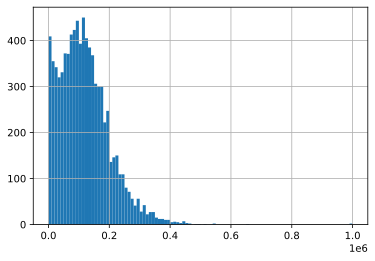

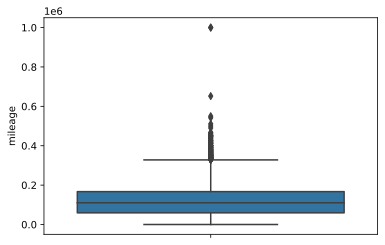

In [ ]:
# Let's look at the distribution of the feature:
visualizing_number(data['mileage'])

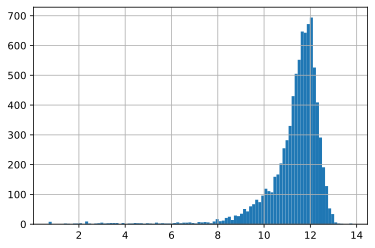

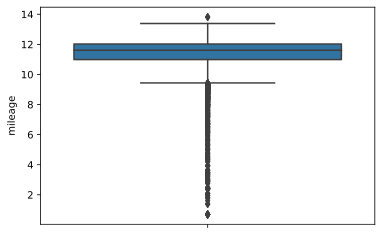

In [ ]:
# The distribution is shifted to the left. Let's look at it after taking the logarithm
visualizing_number(np.log(data['mileage'] + 1))

In [ ]:
# The distribution shifted to the right, but became normal. Let's update the feature
data['mileage'] = np.log(data['mileage'] + 1)

In [ ]:
num_cols.append('mileage')

### model_date / production_date

In [ ]:
data.model_date.unique()

array([1984, 2011, 2005, 2016, 2009, 2008, 2007, 1989, 2001, 2006, 2013,
       2014, 2015, 2004, 2017, 2018, 2012, 2003, 2019, 2010, 2000, 1990,
       2002, 1998, 1993, 1994, 1999, 1995, 1971, 1996, 1985, 1975, 1992,
       1997, 1987, 1979, 1991, 1982, 1986, 1988, 1981, 1977, 1976])

In [ ]:
data.production_date.unique()

array([1991, 2013, 2008, 2007, 2019, 2017, 2014, 2004, 2012, 2011, 2016,
       2010, 2015, 2005, 2018, 2009, 2006, 2020, 2002, 1995, 2000, 1997,
       1994, 1996, 2003, 1992, 2001, 1999, 1984, 1993, 1998, 1986, 1982,
       1990, 1985, 1988, 1987, 1983, 1989])

In [ ]:
# Let's calculate the age of the car
data['model_age'] = data['model_date'].max() - data['model_date'] # model age
data['car_age'] = data['production_date'].max() - data['production_date'] # car age

In [ ]:
# Remove essentially duplicate features
data = data.drop(['model_date', 'production_date'], 1)

In [ ]:
# Let's check for outliers
print(get_outliers(data['model_age']))
print(get_outliers(data['car_age']))

(191, -5.5, 22.5)
(144, -6.5, 21.5)


In [ ]:
# Let's look at ages of cars and models > (Q3 + 1.5 * IQR)
print(data.loc[data['model_age'] > 23.5].model_age.unique())
print(data.loc[data['car_age'] > 20.5].car_age.unique())

[35 30 29 26 25 24 48 34 44 27 32 40 28 37 33 31 38 42 43]
[29 25 23 26 24 28 21 36 27 22 34 38 30 35 32 33 37 31]


In [ ]:
# Let's look at cars over 29 years old
data.loc[data['car_age'] > 29]

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_info,name,number_of_doors,sell_id,vehicle_configuration,vehicle_transmission,owners,ownership,vehicle_passport,car_drive,steering_wheel,sample,price,model_age,car_age
428,OTHER,MERCEDES,синий,Продаю машину легенду – знаменитый SL в 107 ку...,6,3,бензин,11.512935,SL_KLASSE,380 3.8 AT (204 л.с.),2,1099815170,ROADSTER AUTOMATIC 3.8,автоматическая,1 владелец,NaN,Дубликат,задний,Левый,0,0.0,48,36
519,купе,MERCEDES,серый,Самый топовый Мерседес S 560 версия КУПЕ! Авт...,7,3,бензин,11.805603,S_KLASSE,420 4.2 AT (224 л.с.),2,1097292860,COUPE AUTOMATIC 4.2,автоматическая,3 или более,29 лет и 7 месяцев,Оригинал,задний,Левый,0,0.0,34,34
582,купе,MERCEDES,красный,полностю отрестоврирован все вопросы по тел\n ...,3,1,бензин,12.213718,W123,230 2.3 AT (136 л.с.),2,1083142112,COUPE AUTOMATIC 2.3,автоматическая,3 или более,3 года и 7 месяцев,Оригинал,задний,Левый,0,0.0,44,38
748,купе,BMW,зелёный,"Автомобиль в отличном состоянии,номер 850 77, ...",9,5,бензин,11.995358,8ER,850i 5.0 AT (300 л.с.),2,1089826118,COUPE_HARDTOP AUTOMATIC 5.0,автоматическая,3 или более,NaN,Дубликат,задний,Левый,0,0.0,30,30
1240,седан,BMW,чёрный,Всю зиму прожили с ней в сервисе) взял с мёртв...,3,2,бензин,12.966881,5ER,520i 2.0 MT (150 л.с.),4,1098566806,SEDAN MECHANICAL 2.0,механическая,3 или более,9 месяцев,Дубликат,задний,Левый,0,0.0,32,30
1362,внедорожник,MERCEDES,чёрный,Обновлено 01.08. Срочно продам!\n\nНа полном х...,5,1,дизель,11.918397,G_KLASSE,300 3.0d MT (113 л.с.) 4WD,3,1096862184,ALLROAD_3_DOORS MECHANICAL 3.0,механическая,3 или более,NaN,Дубликат,полный,Левый,0,0.0,40,30
1402,седан,MERCEDES,серебристый,"Тому кто понимает что за автомобиль,а не прост...",7,3,бензин,12.587931,S_KLASSE,420 4.2 AT (204 л.с.),4,1078110773,SEDAN AUTOMATIC 4.2,автоматическая,3 или более,NaN,Дубликат,задний,Левый,0,0.0,34,35
1603,седан,MERCEDES,синий,Mercedes-Benz 300 SE. Автомобиль привезён из Г...,5,2,бензин,11.302217,S_KLASSE,300 3.0 AT (180 л.с.),4,1100204728,SEDAN AUTOMATIC 3.0,автоматическая,1 владелец,NaN,Оригинал,задний,Левый,0,0.0,34,30
1704,седан,MERCEDES,чёрный,"Продажа от собственника! Продаётся надёжный, р...",6,3,бензин,11.608245,S_KLASSE,380 3.8 AT (204 л.с.),4,1098824042,SEDAN AUTOMATIC 3.8,автоматическая,2 владельца,NaN,Оригинал,задний,Левый,1,1500000.0,40,35
2216,седан,MERCEDES,серебристый,Автомобиль в отличном состоянии.\n,3,1,бензин,12.224963,W124,200 2.0 MT (118 л.с.),4,1099977164,SEDAN MECHANICAL 2.0,механическая,3 или более,NaN,Оригинал,задний,Левый,1,650000.0,35,30


Pay attention to the mileage and age of the model - they are close to their maximum values. It looks like a real situation. Let's leave the data unchanged.

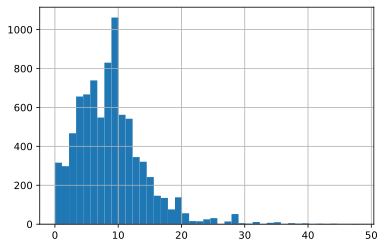

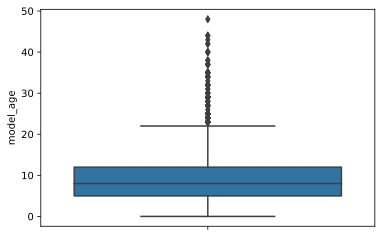

In [ ]:
# Let's look at the distribution of the features
visualizing_number(data['model_age'])

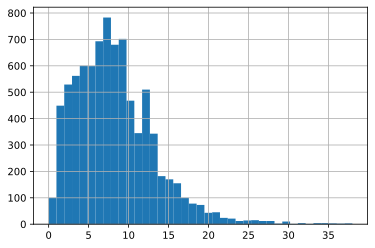

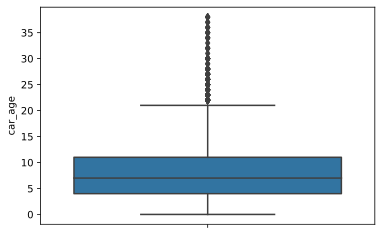

In [ ]:
visualizing_number(data['car_age'])

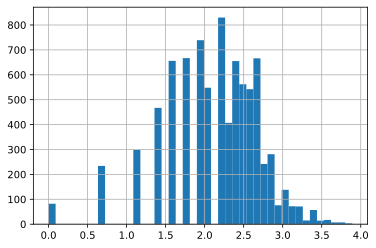

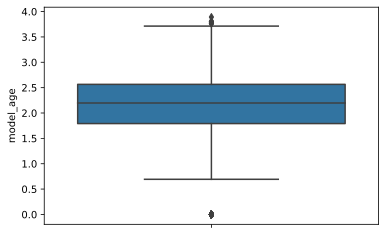

In [ ]:
# The distributions are shifted to the left. Let's look at them after taking the logarithms
visualizing_number(np.log(data['model_age'] + 1))

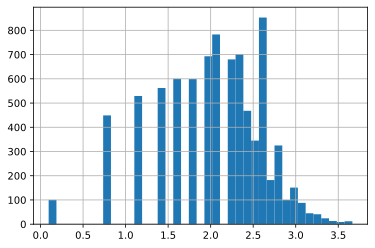

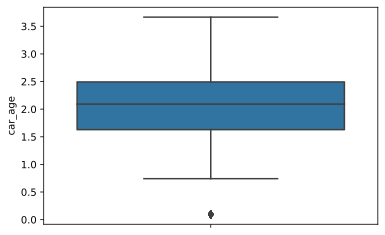

In [ ]:
visualizing_number(np.log(data['car_age']+1.1))

In [ ]:
# The distributions shifted to the right, but became more normal. Let's update the features
data['model_age'] = np.log(data['model_age']+1.1)
data['car_age'] = np.log(data['car_age']+1.1)

In [ ]:
num_cols.append('model_age')
num_cols.append('car_age')

### model_info

In [ ]:
data.model_info.value_counts()

5ER         776
3ER         578
X5          501
E_KLASSE    490
A6          433
           ... 
CITAN         1
None          1
SQ7           1
X3_M          1
W123          1
Name: model_info, Length: 122, dtype: int64

Decrease the dimension of the feature

In [ ]:
# Let's create a mini dataset with colors
model_info_min = data.groupby(['model_info']).size().reset_index(name='counts') 

In [ ]:
# Let's leave all popular values in the mini dataset (the number of entries > 20 times)
model_info_min_popular = model_info_min.loc[model_info_min.counts > 20]['model_info'].unique()

In [ ]:
# Let's replace all unpopular values with the new combined group OTHER
for i in model_info_min['model_info']:
    if i not in model_info_min_popular:
        data.loc[data['model_info'] == i, 'model_info'] = 'OTHER'

In [ ]:
data.model_info.value_counts()

5ER                     776
3ER                     578
X5                      501
E_KLASSE                490
A6                      433
OTHER                   414
A4                      297
S_KLASSE                282
7ER                     276
C_KLASSE                274
X6                      269
X3                      268
Q7                      205
Q5                      196
A5                      186
1ER                     179
M_KLASSE                169
X1                      158
GL_KLASSE               141
A3                      132
A8                      129
G_KLASSE                113
6ER                     107
CLS_KLASSE               94
Q3                       87
GLK_KLASSE               84
A7                       82
GLC_KLASSE               78
G_KLASSE_AMG             71
X4                       70
CLA_KLASSE               68
V_KLASSE                 66
S_KLASSE_AMG             65
4                        65
A_KLASSE                 62
X6_M                

In [ ]:
cat_cols.append('model_info')

### name

In [ ]:
data.name.value_counts()

35i 3.0 AT (306 л.с.) 4WD     151
2.0 AMT (211 л.с.) 4WD        145
200 2.0 AT (184 л.с.)         137
30d 3.0d AT (249 л.с.) 4WD    109
400 3.0 AT (333 л.с.) 4WD      97
                             ... 
30i 3.0 MT (231 л.с.) 4WD       1
50i 4.4 AT (462 л.с.) 4WD       1
318d 2.0d AT (116 л.с.)         1
2.3 MT (133 л.с.) 4WD           1
63 AMG 5.5 AT (557 л.с.)        1
Name: name, Length: 976, dtype: int64

This feature is not valuable to us, let's remove it.

In [ ]:
data = data.drop('name', 1)

### number_of_doors

In [ ]:
data['number_of_doors'].value_counts()

5    3854
4    3636
2     802
3      61
Name: number_of_doors, dtype: int64

In [ ]:
cat_cols.append('number_of_doors')

### sell_id

In [ ]:
data.sell_id.unique()

array([1099427284, 1096405886, 1100195294, ..., 1095155628, 1099625256,
       1097146066])

This feature is not valuable to us, we'll remove it later.

### vehicle_configuration

In [ ]:
data['vehicle_configuration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0     1292
SEDAN AUTOMATIC 2.0                941
SEDAN AUTOMATIC 3.0                631
ALLROAD_5_DOORS AUTOMATIC 2.0      524
ALLROAD_5_DOORS ROBOT 2.0          226
                                  ... 
CABRIO ROBOT 5.0                     1
ROADSTER AUTOMATIC 3.8               1
SEDAN MECHANICAL 4.2                 1
SEDAN MECHANICAL 3.2                 1
HATCHBACK_3_DOORS VARIATOR 1.7       1
Name: vehicle_configuration, Length: 312, dtype: int64

Let's take a closer look at the configuration: the first value indicates the body_type of car, the second - the vehicle transmission, and the third - the engine displacement. We have all this parameters. Let's remove it.

In [ ]:
data = data.drop('vehicle_configuration', 1)

### vehicle_transmission

In [ ]:
data.vehicle_transmission.value_counts()

автоматическая      6560
роботизированная    1201
вариатор             406
механическая         186
Name: vehicle_transmission, dtype: int64

In [ ]:
cat_cols.append('vehicle_transmission')

### owners

In [ ]:
data['owners'].value_counts()

3 или более    3311
1 владелец     2526
2 владельца    2515
Name: owners, dtype: int64

In [ ]:
# Let's look at missing values
data[data['owners'].isnull()]

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_info,number_of_doors,sell_id,vehicle_transmission,owners,ownership,vehicle_passport,car_drive,steering_wheel,sample,price,model_age,car_age
6665,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,7,6,бензин,11.982935,OTHER,4,1019330519,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,1,600000.0,3.049273,3.00072


In [ ]:
# Let's fill in the missing value for the most popular feature value
data['owners'] = data['owners'].fillna('3 или более')

In [ ]:
cat_cols.append('owners')

### ownership

In [ ]:
data['ownership'].value_counts()

1 год и 2 месяца       67
1 год и 8 месяцев      67
1 год                  55
9 месяцев              52
1 год и 10 месяцев     52
                       ..
13 лет и 8 месяцев      1
14 лет и 5 месяцев      1
23 года и 4 месяца      1
14 лет и 1 месяц        1
15 лет и 10 месяцев     1
Name: ownership, Length: 180, dtype: int64

In [ ]:
# Let's look at missing values
data['ownership'].isna().sum()

5418

In [ ]:
((data['ownership'].isna().sum()) / len(data)) * 100

64.86292350053873

64% of missing values is a critical. Let's remove the feature

In [ ]:
data = data.drop('ownership', 1)

### vehicle_passport

In [ ]:
data['vehicle_passport'].value_counts()

Оригинал    7474
Дубликат     879
Name: vehicle_passport, dtype: int64

In [ ]:
bin_cols.append('vehicle_passport')

### сar_drive

In [ ]:
data['car_drive'].value_counts()

полный      5218
задний      2259
передний     876
Name: car_drive, dtype: int64

In [ ]:
cat_cols.append('car_drive')

### steering_wheel

In [ ]:
data['steering_wheel'].value_counts()

Левый     8351
Правый       2
Name: steering_wheel, dtype: int64

In [ ]:
data.loc[data['steering_wheel'] == 'Правый']

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_info,number_of_doors,sell_id,vehicle_transmission,owners,vehicle_passport,car_drive,steering_wheel,sample,price,model_age,car_age
2778,купе,AUDI,красный,"Эксклюзивное авто, собрано в Японии. Правый ру...",2,2,бензин,12.061977,TT,2,1098344588,автоматическая,3 или более,Дубликат,передний,Правый,1,450000.0,2.839078,2.839078
3188,OTHER,BMW,синий,"Продам автомобиль, сборка Мюнхен, Бавария, экс...",3,2,дизель,10.668979,OTHER,5,1091158456,автоматическая,1 владелец,Оригинал,передний,Правый,1,1500000.0,1.629241,1.629241


Since this binary feature has only 2 values against all the others in the train, we'll remove the feature.

In [ ]:
data = data.drop('steering_wheel', 1)

## Significance analysis / Label Encoding / One Hot Encoding

In [ ]:
print(bin_cols)
print(num_cols)
print(cat_cols)

['vehicle_passport']
['mileage', 'model_age', 'car_age']
['body_type', 'brand', 'color', 'engine_displacement', 'engine_power', 'fuel_type', 'model_info', 'number_of_doors', 'vehicle_transmission', 'owners', 'car_drive']


### Binary features

In [ ]:
# Let's apply the method Label Encoding to binary features
label_encoder = LabelEncoder()
for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])
    
data[bin_cols].head(5)

,vehicle_passport
0,1
1,1
2,1
3,1
4,1


### Numerical features

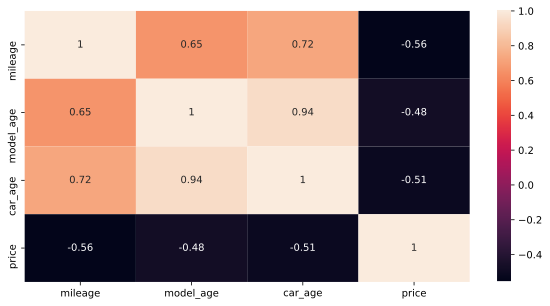

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

The car price is quite strongly influenced by 3 features: mileage, car_age and model_age. The parameters car_age / model_age (0.94!), as well as mileage / model_age and mileage / car_age, are strongly correlated with each other.

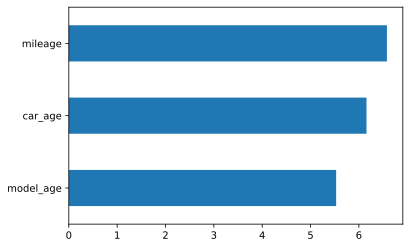

In [ ]:
# Let's look at the significance of continuous variables
imp_num = Series(f_classif(data[data['price'].isna() == False][num_cols], 
                           data[data['price'].isna() == False]['price'])[0], 
                           index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
# Remove the model_age parameter and leave the identical feature car_age
#data = data.drop('model_age', 1)
#num_cols.remove('model_age')

### Categorical features

In [ ]:
# Let's apply the method Label Encoding to categorical features
for i in cat_cols:
    label_encoder.fit(data[i])
    data[i] = label_encoder.transform(data[i])

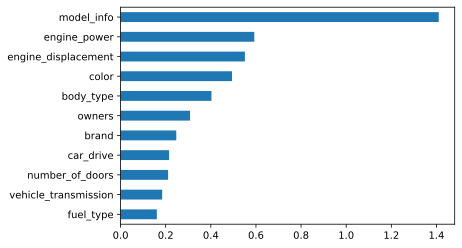

In [ ]:
# Let's look at the significance of categorical variables
imp_cat = Series(mutual_info_classif(data[data['price'].isna() == False][cat_cols], 
                                     data[data['price'].isna() == False]['price'],
                                     discrete_features = True), index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

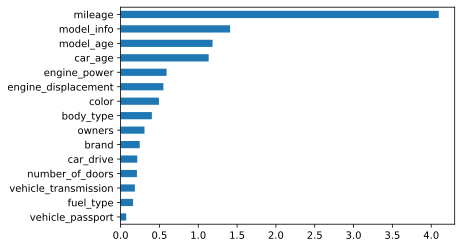

In [ ]:
# Let's see the significance of all variables on one chart
imp_cat = Series(mutual_info_classif(data[data['price'].isna() == False][cat_cols + num_cols + bin_cols], 
                                     data[data['price'].isna() == False]['price'],
                                     discrete_features = True), index = cat_cols + num_cols + bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Interesting observations:

- the three most significant characteristics of used cars are mileage, car_age and engine power,
- the color of the car influences the choice of buyers to a greater extent than the types of car_drive or transmission.

#### Subtotal EDA
We have processed all the features:

- defined the types of variables,
- eliminated missing values,
- analyzed emissions,
- standardized the general view of the data,
- analyzed the relationship of features with each other and with the target,
- removed the least valuable parameters from the dataset.

## Feature Engeneering

### Tabular

#### mileage_year

Let's create a new mileage_year variable, which will show the average mileage of the car per year.

In [ ]:
data['mileage_year'] = (data['mileage'] / data['car_age']).astype(float)

In [ ]:
num_cols.append('mileage_year')

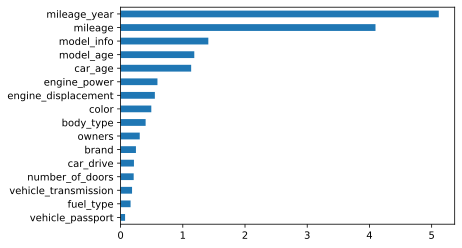

In [ ]:
imp_cat = Series(mutual_info_classif(data[data['price'].isna() == False][cat_cols + num_cols + bin_cols], 
                                     data[data['price'].isna() == False]['price'],
                                     discrete_features = True), index = cat_cols + num_cols + bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Now let's standardize numeric variables

In [ ]:
scaler = MinMaxScaler()
for column in num_cols:
  data[column] = scaler.fit_transform(data[[column]])[:,0]

Let's duplicate our dataset before the final changes. This will allow us to optimize it as needed for each model.

In [ ]:
data.head(3)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_info,number_of_doors,sell_id,vehicle_transmission,owners,vehicle_passport,car_drive,sample,price,model_age,car_age,mileage_year
0,6,2,11,Всем привет!\n\nПродам эксклюзивный проект 124...,5,3,1,0.919998,37,3,1099427284,0,2,1,0,0,0.0,0.919031,0.926740,0.031283
1,2,1,2,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,5,5,2,0.679963,4,0,1096405886,0,0,1,2,0,0.0,0.556256,0.559132,0.039731
2,2,1,0,"Машина тут продаётся не в первый раз, НО! Толь...",4,3,1,0.863427,1,0,1100195294,0,2,1,2,0,0.0,0.689575,0.693764,0.040497


In [ ]:
data_1 = data.copy()

In [ ]:
# Let's remove irrelevant features from our dataset
data_1 = data_1.drop(['description', 'sell_id'], 1)

In [ ]:
# Let's transform categorical features into dummy variables (One Hot Encoding) 
data_1 = pd.get_dummies(data_1, columns=cat_cols)

In [ ]:
data_1.head(3)

,mileage,vehicle_passport,sample,price,model_age,car_age,mileage_year,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,body_type_7,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,engine_displacement_0,engine_displacement_1,engine_displacement_2,engine_displacement_3,engine_displacement_4,engine_displacement_5,engine_displacement_6,engine_displacement_7,engine_displacement_8,engine_displacement_9,...,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,number_of_doors_0,number_of_doors_1,number_of_doors_2,number_of_doors_3,vehicle_transmission_0,vehicle_transmission_1,vehicle_transmission_2,vehicle_transmission_3,owners_0,owners_1,owners_2,car_drive_0,car_drive_1,car_drive_2
0,0.919998,1,0,0.0,0.919031,0.926740,0.031283,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0
1,0.679963,1,0,0.0,0.556256,0.559132,0.039731,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
2,0.863427,1,0,0.0,0.689575,0.693764,0.040497,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1


### NLP

In [ ]:
data_2 = data.copy()

#### description

In [ ]:
data_2.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [ ]:
cleaned_description = re.sub('[^А-Яа-я0-9]+', ' ', data_2.description[0]).lower()

In [ ]:
cleaned_description = []
for i in data_2.description:
  cleaned_description.append(re.sub('[^А-Яа-я0-9]+', ' ', i).lower())

In [ ]:
data_2['description'] = pd.Series((v for v in cleaned_description))

In [ ]:
data_2.description

0       всем привет продам эксклюзивный проект 124 уни...
1       продаю любимейшую тачилу обвес и тюнинг потому...
2       машина тут прода тся не в первый раз но только...
3       автомобиль в отличном состоянии весь в родной ...
4       немка с бесключивым доступом и камерой заднего...
                              ...                        
8348    прода тся любимый автомобиль за годы эксплуата...
8349    куплена у официального дилера в 2017 г третий ...
8350    торг на месте все работает сборка немецкая рез...
8351    автомобиль в отличном состоянии 3 из авто в се...
8352    удлиненный заводской на базе 140 вообще то пра...
Name: description, Length: 8353, dtype: object

In [ ]:
# nltk tokenization
tokens_description = []
for i in data_2.description:
  tokens = nltk.word_tokenize(i)
  tokens_description.append(tokens)

In [ ]:
# nltk stop_words
filtered_description = []
stop_words = stopwords.words('russian')
for i in tokens_description:
  word_ = [word for word in i if word not in stop_words]
  filtered_description.append(word_)
print(filtered_description[0])
print(len(filtered_description[0]))

['всем', 'привет', 'продам', 'эксклюзивный', 'проект', '124', 'универсал', '300', '24', 'модель', '124', '091', '300', '24', 'двигатель', '104', '980', 'трансмиссия', '722', '359', 'цвет', 'кузова', '040', 'черный', 'отделка', 'салона', '271', 'кожа', 'черная', 'антрацит', 'опции', '211', 'автоматическая', 'блокировка', 'дифференциала', '240', 'индикатор', 'внешней', 'температуры', '244', 'спортивные', 'сиденья', 'спереди', '281', 'спортивное', 'рулевое', 'колесо', 'отделкой', 'кожи', 'диаметр', '390', 'мм', 'кожаный', 'рычаг', 'кпп', '291', 'подушка', 'безопасности', 'водителя', 'переднего', 'пассажира', '300', 'дополнительный', 'бардачок', 'вещевом', 'отсеке', 'спереди', '412', 'люк', 'электроприводом', 'устройством', 'подъ', 'ма', '420', 'автоматическая', 'коробка', 'передач', 'напольное', 'исполнение', '440', 'темпомат', 'круиз', 'контроль', '538', 'автоматическая', 'антенна', '541', 'двойные', 'занавески', 'багажного', 'пространства', 'пасажирского', 'отсека', 'сетка', 'шторка', '

In [ ]:
# pymorphy2 lemmatization
lemma_description = []
morph = pymorphy2.MorphAnalyzer()
for i in filtered_description:
  pre_lemma = []
  for k in i:
    word_ = morph.parse(k)[0].normal_form
    pre_lemma.append(word_)
  lemma_description.append(pre_lemma)

In [ ]:
data_2['description'] = pd.Series((v for v in lemma_description))

In [ ]:
strings = []
for string in data_2.description:
  string = ' '.join(string)
  strings.append(string)

In [ ]:
data_2['description'] = pd.Series((v for v in strings))

In [ ]:
data_2['description']

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес тюнинг ездить до...
2       машина прод тся первый перебрать двигатель зам...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    прод тся любимый автомобиль год эксплуатация м...
8349    купить официальный дилер 2017 г третий владеле...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние 3 авто семья обс...
8352    удлинённый заводский база 140 вообще правильно...
Name: description, Length: 8353, dtype: object

# ML

## Split data

In [ ]:
# Now let's separate the test and train parts
train_data_1 = data_1.query('sample == 1').drop(['sample'], axis=1)
test_data_1 = data_1.query('sample == 0').drop(['sample'], axis=1)

In [ ]:
y = train_data_1.price.values # target

X = train_data_1.drop(['price'], axis=1)
X_sub = test_data_1.drop(['price'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                    shuffle=True, random_state=RANDOM_SEED)

## Model 2: CatBoostRegressor

In [ ]:
cb = CatBoostRegressor(iterations = 6000,
                      #depth=10,
                      #learning_rate = 0.05,
                      random_seed = RANDOM_SEED,
                      eval_metric='MAPE',
                      custom_metric=['RMSE', 'MAE'],
                      od_wait=700
                      )

cb.fit(X_train, y_train,
       eval_set=(X_test, y_test),
       verbose_eval=100,
       use_best_model=True,
       plot=True
       )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.020953
0:	learn: 0.9892146	test: 1.0137980	best: 1.0137980 (0)	total: 49.4ms	remaining: 4m 56s
100:	learn: 0.3423160	test: 0.3498390	best: 0.3498390 (100)	total: 337ms	remaining: 19.7s
200:	learn: 0.2294252	test: 0.2335321	best: 0.2335321 (200)	total: 631ms	remaining: 18.2s
300:	learn: 0.1914953	test: 0.1964920	best: 0.1964920 (300)	total: 913ms	remaining: 17.3s
400:	learn: 0.1760474	test: 0.1817736	best: 0.1817736 (400)	total: 1.24s	remaining: 17.4s
500:	learn: 0.1675210	test: 0.1728700	best: 0.1728700 (500)	total: 1.53s	remaining: 16.8s
600:	learn: 0.1606422	test: 0.1662232	best: 0.1662232 (600)	total: 1.83s	remaining: 16.4s
700:	learn: 0.1542872	test: 0.1599783	best: 0.1599783 (700)	total: 2.18s	remaining: 16.5s
800:	learn: 0.1486189	test: 0.1552445	best: 0.1552445 (800)	total: 2.46s	remaining: 16s
900:	learn: 0.1438539	test: 0.1510401	best: 0.1510401 (900)	total: 2.74s	remaining: 15.5s
1000:	learn: 0.1396235	test: 0.1480054	best: 0.1480054 (1000)	total: 3.14s

In [ ]:
test_predict_catboost = cb.predict(X_test)
print(f"Accuracy of a catboost model by metric MAPE: {(mape(y_test, test_ptrdict_catboost))*100:0.2f}%")

Accuracy of a catboost model by metric MAPE: 12.63%


In [ ]:
pickle.dump(cb, open(f'/content/gdrive/MyDrive/Colab Notebooks/SF/PROJECTS/Car Price Prediction_Part 2/models/catboost_model.sav', 'wb'))

## Model 3: Tabular NN

Let's build a regular neural network

In [ ]:
X_train.head(5)

,mileage,vehicle_passport,model_age,car_age,mileage_year,body_type_0,body_type_1,body_type_2,body_type_3,body_type_4,body_type_5,body_type_6,body_type_7,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,engine_displacement_0,engine_displacement_1,engine_displacement_2,engine_displacement_3,engine_displacement_4,engine_displacement_5,engine_displacement_6,engine_displacement_7,engine_displacement_8,engine_displacement_9,engine_displacement_10,engine_displacement_11,...,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,number_of_doors_0,number_of_doors_1,number_of_doors_2,number_of_doors_3,vehicle_transmission_0,vehicle_transmission_1,vehicle_transmission_2,vehicle_transmission_3,owners_0,owners_1,owners_2,car_drive_0,car_drive_1,car_drive_2
7320,0.855429,1,0.631266,0.620930,0.045286,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
8037,0.705392,1,0.346363,0.290156,0.081587,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
4681,0.846775,1,0.706456,0.733554,0.037255,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1
6014,0.915514,1,0.671537,0.714365,0.041777,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0
3649,0.842142,1,0.556256,0.559132,0.049877,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1


### Simple Dense NN

In [ ]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               65536     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 197,121
Trainable params: 197,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # in fact we learn the model until EarlyStopping stops it
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

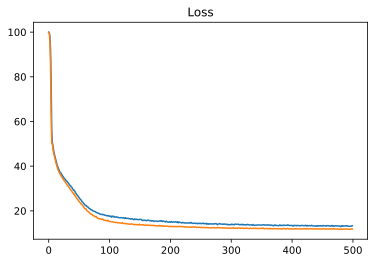

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
y_pred_nn1 = model.predict(X_test)
print(f"Accuracy of a NN model by metric MAPE: {(mape(y_test, y_pred_nn1[:,0]))*100:0.2f}%")

Accuracy of a NN model by metric MAPE: 11.92%


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/SF/PROJECTS/Car Price Prediction_Part 2/models//nn_1.hdf5')

In [ ]:
#model.load_weights('../nn_1.hdf5')

## Model 4: NLP + Multiple Inputs¶

In [ ]:
data_3 = data_2.copy() 

In [ ]:
data_2 = data_2.drop('sell_id', 1)

In [ ]:
data_2.head(3)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,mileage,model_info,number_of_doors,vehicle_transmission,owners,vehicle_passport,car_drive,sample,price,model_age,car_age,mileage_year
0,6,2,11,весь привет продать эксклюзивный проект 124 ун...,5,3,1,0.919998,37,3,0,2,1,0,0,0.0,0.919031,0.926740,0.031283
1,2,1,2,продавать любимый тачил обвес тюнинг ездить до...,5,5,2,0.679963,4,0,0,0,1,2,0,0.0,0.556256,0.559132,0.039731
2,2,1,0,машина прод тся первый перебрать двигатель зам...,4,3,1,0.863427,1,0,0,2,1,2,0,0.0,0.689575,0.693764,0.040497


In [ ]:
data_2.description

0       весь привет продать эксклюзивный проект 124 ун...
1       продавать любимый тачил обвес тюнинг ездить до...
2       машина прод тся первый перебрать двигатель зам...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    прод тся любимый автомобиль год эксплуатация м...
8349    купить официальный дилер 2017 г третий владеле...
8350    торг место работать сборка немецкий резина лет...
8351    автомобиль отличный состояние 3 авто семья обс...
8352    удлинённый заводский база 140 вообще правильно...
Name: description, Length: 8353, dtype: object

In [ ]:
# Let's transform categorical features into dummy variables (One Hot Encoding) 
data_2 = pd.get_dummies(data_2, columns=cat_cols)

In [ ]:
# split data
train_data_2 = data_2.query('sample == 1').drop(['sample'], axis=1)
test_data_2 = data_2.query('sample == 0').drop(['sample'], axis=1)

y = train_data_2.price.values # target

X = train_data_2.drop(['price'], axis=1)
X_sub = test_data_2.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                    shuffle=True, random_state=RANDOM_SEED)

X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]

In [ ]:
text_train = data_2.description.iloc[X_train.index]
text_test = data_2.description.iloc[X_test.index]
text_sub = data_2.description.iloc[X_sub.index]

In [ ]:
# The maximum number of words to be used (most frequent)
MAX_WORDS = 100000
# The maximum number of words in each complaint
MAX_SEQUENCE_LENGTH = 256

In [ ]:
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_2.description)

In [ ]:
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)


In [ ]:
# Text in vector space
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобиль проверить 110 пункт автокредит специальный ставка 13 7 ауди центр север официальный дилер входящий группа компания рольф являться один крупный дилер европа предлагать ряд услуга покупка продажа автомобиль пробег протяжение многий год наш дилерский центр являться лидер продажа автомобиль пробег среди дилер россия предоставлять клиент самый большой выбор автомобиль пробег другой марка каждый автомобиль проходить тщательный диагностик подготовка гарантировать находиться отличный состояние убедиться правильный выбор возможность пройти тест драйв ознакомительный поездка интересовать автомобиль смочь ознакомиться автомобиль выходить дом наш менеджер провести презентация видеозвонок показать выбрать автомобиль также ауди центр север представлять уникальный предложение кредитование автомобиль пробег индивидуальный условие специалист компания подобрать хороший условие кредитование 6 000 проверить автомобиль пробег гарантия 2 год ждать сайт мобильный приложение рольф
[   0    0    0  

### RNN NLP

In [ ]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [ ]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [ ]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     4417280     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
______________________________________________________________________________________________

### Fit

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
%time
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.48 µs
Epoch 1/500
12/12 [==============================] - 13s 561ms/step - loss: 99.9900 - MAPE: 99.9900 - val_loss: 99.8728 - val_MAPE: 99.8728
Epoch 2/500
12/12 [==============================] - 5s 435ms/step - loss: 98.7629 - MAPE: 98.7629 - val_loss: 94.2747 - val_MAPE: 94.2747
Epoch 3/500
12/12 [==============================] - 5s 425ms/step - loss: 80.8580 - MAPE: 80.8580 - val_loss: 52.9435 - val_MAPE: 52.9435
Epoch 4/500
12/12 [==============================] - 5s 419ms/step - loss: 53.4172 - MAPE: 53.4172 - val_loss: 48.9105 - val_MAPE: 48.9105
Epoch 5/500
12/12 [==============================] - 5s 416ms/step - loss: 47.8228 - MAPE: 47.8228 - val_loss: 45.6220 - val_MAPE: 45.6220
Epoch 6/500
12/12 [==============================] - 5s 418ms/step - loss: 44.6560 - MAPE: 44.6560 - val_loss: 42.5867 - val_MAPE: 42.5867
Epoch 7/500
12/12 [==============================] - 5s 418ms/step - loss: 42.0824 - MAPE: 42.082

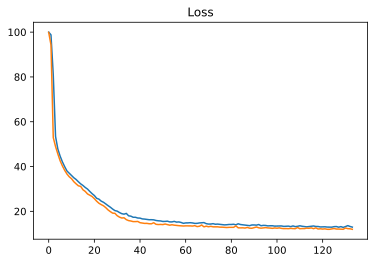

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [ ]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"Accuracy of a multiple NN model by metric MAPE: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

Accuracy of a multiple NN model by metric MAPE: 11.97%


In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/SF/PROJECTS/Car Price Prediction_Part 2/models/nn_mlp_nlp.hdf5')

In [ ]:
#model.load_weights('../nn_mlp_nlp.hdf5')

## Model 5: Let's add images

### Data

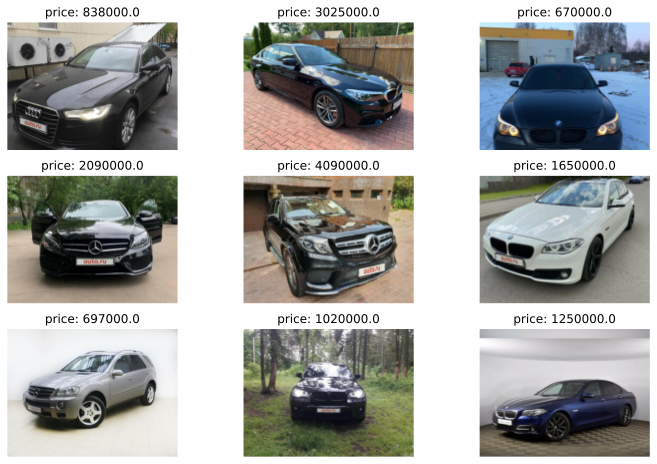

In [ ]:
# Let's make sure that the prices and photos are loaded correctly
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR + 'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [ ]:
%time
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data_3['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs
images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

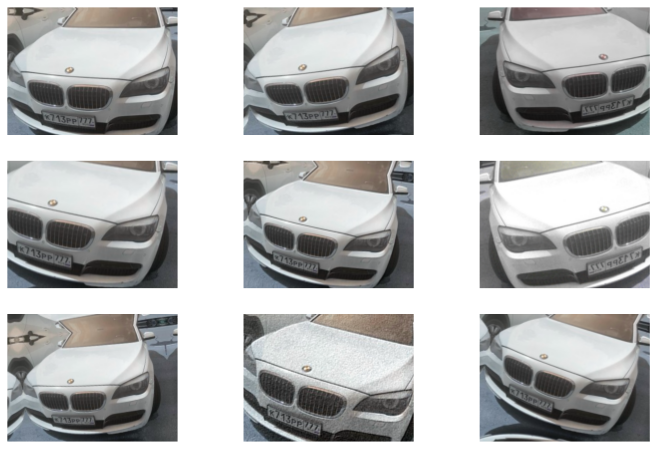

In [ ]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

# The example is taken from the official documentation.: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

# Example
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def make_augmentations(images):
  print('application of augmentation', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

### tf.data.Dataset

In [ ]:
data_3 = data_3.drop('sell_id', 1)

In [ ]:
data_3 = pd.get_dummies(data_3, columns=cat_cols)

In [ ]:
# split data
train_data_3 = data_3.query('sample == 1').drop(['sample'], axis=1)
test_data_3 = data_3.query('sample == 0').drop(['sample'], axis=1)

y = train_data_3.price.values # target

X = train_data_3.drop(['price'], axis=1)
X_sub = test_data_3.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                    shuffle=True, random_state=RANDOM_SEED)

X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]
X_sub = X_sub.iloc[:, 1:]
X = X.iloc[:, 1:]

In [ ]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_3.description)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data_3.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data_3.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data_3.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

# Let's check that there are no errors (no exception will be thrown)
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

Let's build a convolutional network for image analysis without a "head"

In [ ]:
# Normalization is included in the EfficientNetB3 model, so it accepts unit8 data as input.
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, 
                                                                       input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43950080/43941136 [==============================] - 1s 0us/step


In [ ]:
# Let's build a neural network for analyzing tabular data
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [ ]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [ ]:
# We combine the outputs of three neural networks
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# Regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                    )

Epoch 1/100
 78/190 [===========>..................] - ETA: 4:07 - loss: 65.5375 - MAPE: 65.5375

ResourceExhaustedError: ignored

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show()

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"Accuracy of a multiple NN (text + images) model by metric MAPE: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/SF/PROJECTS/Car Price Prediction_Part 2/models/nn_final.hdf5')

In [ ]:
#model.load_weights('../nn_final.hdf5')

## Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

## Model Bonus: 'feature forwarding'

In [ ]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

FEATURE Input

In [ ]:
# Input
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [ ]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])

# Our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [ ]:
model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, 
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

In [ ]:
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"MAPE: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/SF/PROJECTS/Car Price Prediction_Part 2/models/bonus_model.hdf5')

In [1]:
#model.load_weights('../bonus_model.hdf5')

# Total

In this project, I worked with tabular, textual and graphic data.

Also:

- I did the cleanup, removed the stop words and lemmatized the text data,
- I trained several neural networks and combined them,
- I produced an ensemble of a tabular model (CatBoost) and a model with text and graphic data and got the best MAPE metric result.